# Diffusion 在1D/2D的例子

## 加载数据集

In [315]:
import torch
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
ibc_parent_dir = os.path.abspath(os.path.join(notebook_dir, ".."))
sys.path.append(ibc_parent_dir)

import dataset_2d

In [316]:
experiment_name = "dp_step_30" # custom experiment name
custom_seed = 42 # custom seed

train_dataset_size = 30 # custom dataset size
train_batch_size = 8
trian_num_workers = 1

test_dataset_size = 500
test_batch_size = 8
test_num_workers = 1

In [317]:
train_dataset_config = dataset_2d.ToyDatasetConfig(
    dataset_size=train_dataset_size,
    seed=custom_seed,
    mode = 'circle_line',    
)
train_dataset = dataset_2d.Toy1DDataset(train_dataset_config)  # data: coordinate regression shape:（N,2)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=True,
    num_workers=trian_num_workers,
    pin_memory=torch.cuda.is_available(),
)

# Test split.
test_dataset_config = dataset_2d.ToyDatasetConfig(
    dataset_size=test_dataset_size,
    seed=custom_seed, 
    mode = 'circle_line',
)
test_dataset = dataset_2d.Toy1DDataset(test_dataset_config)
test_dataset.exclude(train_dataset.coordinates) # 防止测试集中包含训练集的数据
test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
    num_workers=test_num_workers,
    pin_memory=torch.cuda.is_available(),
)

Resampled 30 data points.


batch的类型: <class 'list'>
batch包含的元素数量: 2
batch[0].shape:torch.Size([8, 1])
batch[1].shape:torch.Size([8, 3])
x = torch.Size([1])
y = torch.Size([3])


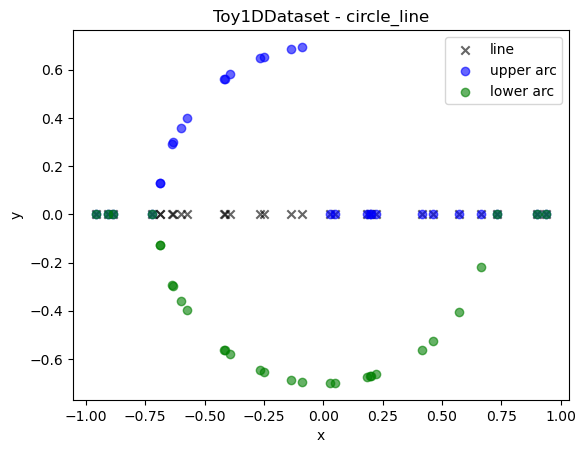

In [318]:
batch = next(iter(train_dataloader))    # 可以更改为test_dataloader查看测试集的shape

print("batch的类型:", type(batch))  # data + label
print("batch包含的元素数量:", len(batch))

for i in range(len(batch)):
    print("batch[{}].shape:{}".format(i, batch[i].shape))

# Visualize one instance.
x, y = train_dataset[np.random.randint(len(train_dataset))]
print("x =", x.shape)
print("y =", y.shape)

xs = train_dataset.coordinates.flatten()
ys = train_dataset.targets  # shape (N, 3) for circle_with_line

plt.figure()

if ys.ndim == 1 or ys.shape[1] == 1:
    # 普通 1D 情况
    plt.scatter(xs, ys.flatten(), marker="x", c="blue", alpha=0.6)

else:
    # 分别绘制 line / upper_arc / lower_arc
    plt.scatter(xs, ys[:, 0], marker="x", c="black", alpha=0.6, label="line")
    plt.scatter(xs, ys[:, 1], marker="o", c="blue", alpha=0.6, label="upper arc")
    plt.scatter(xs, ys[:, 2], marker="o", c="green", alpha=0.6, label="lower arc")

plt.title(f"Toy1DDataset - {train_dataset.mode}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


batch的类型: <class 'list'>
batch包含的元素数量: 2
batch[0].shape:torch.Size([8, 1])
batch[1].shape:torch.Size([8, 3])
x = torch.Size([1])
y = torch.Size([3])
x = tensor([0.8421])
y = tensor([0., 0., 0.])


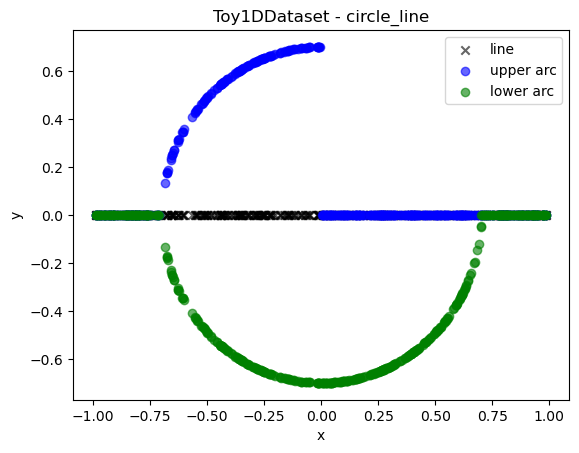

In [319]:
batch = next(iter(test_dataloader)) 

print("batch的类型:", type(batch))  # data + label
print("batch包含的元素数量:", len(batch))

for i in range(len(batch)):
    print("batch[{}].shape:{}".format(i, batch[i].shape))

x, y = test_dataset[np.random.randint(len(train_dataset))]
print("x =", x.shape)
print("y =", y.shape)
print("x =", x)
print("y =", y)

xs = test_dataset.coordinates.flatten()
ys = test_dataset.targets  # shape (N, 3) for circle_with_line

plt.figure()

if ys.ndim == 1 or ys.shape[1] == 1:
    # 普通 1D 情况
    plt.scatter(xs, ys.flatten(), marker="x", c="blue", alpha=0.6)

else:
    # 分别绘制 line / upper_arc / lower_arc
    plt.scatter(xs, ys[:, 0], marker="x", c="black", alpha=0.6, label="line")
    plt.scatter(xs, ys[:, 1], marker="o", c="blue", alpha=0.6, label="upper arc")
    plt.scatter(xs, ys[:, 2], marker="o", c="green", alpha=0.6, label="lower arc")

plt.title(f"Toy1DDataset - {train_dataset.mode}")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


## 搭建网络

需要前向扩散，逆向扩散过程

噪声调度

设计网络，使用MLP网络即可满足要求，但额外还需要：

- condition sample
- predict
- compute loss

In [320]:
import torch.nn as nn
import torch.nn.functional as F
from typing import Dict

# DDPM
from diffusers.schedulers.scheduling_ddpm import DDPMScheduler
# from diffusion_policy.model.common.normalizer import LinearNormalizer

In [321]:
input_dim = 1+3+1  # 1维坐标 + 3维动作 + 1维时间戳
output_dim = 3  # 输出3维动作
class MLP(nn.Module):
    def __init__(self, 
                 input_dim: int,
                 hidden_dims: list[int],
                 output_dim: int, 
                 activation: nn.Module = nn.ReLU(),  # 激活函数（默认ReLU）
                 use_batch_norm: bool = False,       # 是否使用批归一化
                 dropout_rate: float = 0.0):         # Dropout比率（0表示不使用）
        super().__init__()
        
        layers = []
        in_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(in_dim, hidden_dim))
            # 批归一化（可选）
            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(activation)
            # Dropout（可选）
            if dropout_rate > 0:
                layers.append(nn.Dropout(dropout_rate))
            # 更新输入维度为当前隐藏层维度
            in_dim = hidden_dim
        
        # 添加输出层（无激活函数，根据任务自行添加如Softmax）
        layers.append(nn.Linear(in_dim, output_dim))
        
        # 用Sequential包装所有层
        self.net = nn.Sequential(*layers)
        
    # 把所有东西处理好再传入网络
    def forward(self, trajectory: torch.Tensor, timestamp: torch.Tensor, x: torch.Tensor) -> torch.Tensor:
        # print("trajectory shape:", trajectory.shape)
        # print("timestamp shape:", timestamp.shape)
        # t_expanded = timestamp.unsqueeze(1)  # 从 [8] → [8,1]
        # t_expanded = timestamp.unsqueeze(0).unsqueeze(1).repeat(B, 1)
        # B = x.shape[0]
        # print("the original timestamp:", timestamp)
        # print(t_expanded)
        fused = torch.cat([trajectory, timestamp, x], dim=1)
        # print("fused shape:", fused.shape)
        # B, D = fused.size()  # B=8（批次大小），D=5（特征维度）
        out = self.net(fused)
        # out = out.view(B, N, self.config.output_dim)
        # energies = out.mean(dim=-1) # 平均所有输出维度作为能量值
        # return energies
        return out

In [322]:
DiffusionMLP = MLP(
    input_dim=input_dim,
    hidden_dims=[512, 512],  # 2个隐藏层，分别为64和32维
    output_dim=output_dim,
    activation=nn.ReLU(),
    use_batch_norm=True,   # 使用批归一化
    dropout_rate=0.02       # 每层Dropout比率0.2
)
num_inference_steps = 100

关于DiffusionMLP的定义与使用：

去噪网络建模为$\epsilon_{\theta}(O,A,k)$

- 输入使用：dim(O) + dim(A) + dim(k)
- 输出使用：y.shape = (batch_size, 3)
- 不需要normalization, mask, condition

所以，只需要x, y, t, input_dim, outputdim即可 

In [323]:
class DiffusionMlpPolicy():
    def __init__(self, 
        model: MLP,
        noise_scheduler: DDPMScheduler,
        input_dim, 
        output_dim, 
        num_inference_steps=None,
        oa_step_convention=False,
        # parameters passed to step
        **kwargs):
        self.model = model
        self.noise_scheduler = noise_scheduler
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.oa_step_convention = oa_step_convention
        self.kwargs = kwargs
        self.num_inference_steps = num_inference_steps  # 执行多少步的去噪或者采样
        self.num_train_timesteps = num_inference_steps
    
    # ========= inference  ============
    # def conditional_sample(self, condition_data, global_cond, generator=None, **kwargs):
    #     model = self.model
    #     scheduler = self.noise_scheduler

    #     # 随机初始化一个高斯噪声轨迹
    #     trajectory = torch.randn(
    #         size=condition_data.shape, 
    #         dtype=condition_data.dtype,
    #         device=condition_data.device,
    #         generator=generator)
    
    #     # set step values
    #     scheduler.set_timesteps(self.num_inference_steps)

    #     for diffusion_t in scheduler.timesteps:
    #         # 噪声预测
    #         print("timestamp shape:", diffusion_t)  # torch.Size([])
    #         model_output = model(trajectory, diffusion_t, global_cond)

    #         # 去噪过程
    #         trajectory = scheduler.step(
    #             model_output, t, trajectory, 
    #             generator=generator,
    #             **kwargs
    #             ).prev_sample      

    #     return trajectory
    
    def conditional_sample(self, condition_data, global_cond, generator=None, **kwargs):
        model = self.model
        scheduler = self.noise_scheduler

        # 随机初始化一个高斯噪声轨迹
        trajectory = torch.randn(
            size=condition_data.shape, 
            dtype=condition_data.dtype,
            device=condition_data.device,
            generator=generator)

        # 设置采样步数
        scheduler.set_timesteps(self.num_inference_steps)
        B = trajectory.shape[0]  # 获取批次大小

        for diffusion_t in scheduler.timesteps:
            # 关键修正：将标量时间步扩展为 [B, 1]，与批次大小匹配
            t_expanded = diffusion_t.repeat(B).unsqueeze(1).to(trajectory.device)
            # print("expanded timestamp shape:", t_expanded.shape)  # torch.Size([8, 1])
            # 噪声预测（使用扩展后的时间步）
            model_output = model(trajectory, t_expanded, global_cond)

            # 去噪过程
            trajectory = scheduler.step(
                model_output, diffusion_t, trajectory,  # 注意这里仍用原始diffusion_t（scheduler需要标量时间步）
                generator=generator,** kwargs
            ).prev_sample      

        return trajectory
    
    def predict_action(self, batch):
        global_cond, condition_data = batch
        # print("x shape:", global_cond.shape)  # [8,1]
        # print("y shape:", condition_data.shape)  # [8,3]
        Da = self.output_dim

        # run sampling
        nsample = self.conditional_sample(
            condition_data, global_cond,
            **self.kwargs)
        
        # unnormalize prediction
        action_pred = nsample[...,:Da]
     
        result = {
            'action_pred': action_pred
        }
        return result
    
    def compute_loss(self, batch):
        x, y = batch
        global_cond = x
        trajectory = y
        # print("x shape:", x.shape)
        # print("target shape:", target.shape)

        # Sample noise that we'll add to the images
        noise = torch.randn(trajectory.shape, device=trajectory.device)
        bsz = trajectory.shape[0]
        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, self.num_train_timesteps, 
            (bsz,), device=trajectory.device
        ).long()
        # print("timesteps shape in comute loss:", timesteps.shape)  # torch.Size([8])
        t_expanded = timesteps.unsqueeze(1)  # 从 [8] → [8,1]
        # print("t_expanded shape in comute loss:", t_expanded.shape)  # torch.Size([8])
        # Add noise to the clean images according to the noise magnitude at each timestep
        # (this is the forward diffusion process)
        noisy_trajectory = self.noise_scheduler.add_noise(
            trajectory, noise, timesteps)
        
        # Predict the noise residual
        pred = self.model(noisy_trajectory, t_expanded, global_cond)

        loss = F.mse_loss(pred, y, reduction='none')
        loss = loss.mean()
        return loss

粗略的写完了diffusion的sample和compute loss，下一步开始train和debug

In [ ]:
from diffusion_policy.model.common.lr_scheduler import get_scheduler
import tqdm
num_epochs = 1000
learning_rate = 1e-3
weight_decay = 1e-5

dpp = DiffusionMlpPolicy(model = DiffusionMLP,
                         noise_scheduler = DDPMScheduler(),
                            input_dim = input_dim,
                            output_dim = output_dim,
                            num_inference_steps = num_inference_steps)
optimizer = torch.optim.AdamW(dpp.model.parameters(), lr=learning_rate, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer=optimizer,
    step_size=10 * len(train_dataloader),  # 每10轮衰减一次（按批次算）
    gamma=0.9,  # 衰减系数
)


In [325]:
# 外层循环：总训练轮次（用tqdm显示整体进度）
for local_epoch_idx in tqdm.tqdm(range(num_epochs), desc="Total Training Progress"):
    step_log = dict()
    train_losses = list()  # 记录当前epoch所有批次的loss 
      
    for batch in train_dataloader:
        loss = dpp.compute_loss(batch)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        lr_scheduler.step()
        
        loss_cpu = loss.item()
        train_losses.append(loss_cpu)
        
        # 构建日志字典
        step_log = {
            'train_loss': loss_cpu,
            'lr': lr_scheduler.get_last_lr()[0] 
        }
        
        # is_last_batch = (batch_idx == len(train_dataloader) - 1)
        
        # if not is_last_batch:
        #     pass
        # else:
        avg_loss = sum(train_losses) / len(train_losses)
        # print(f"Epoch {local_epoch_idx} 平均loss: {avg_loss:.4f}")

print(step_log)

Total Training Progress: 100%|██████████| 5000/5000 [05:41<00:00, 14.66it/s]

{'train_loss': 0.008753223344683647, 'lr': 1.3220708194808223e-26}


训练完了，试一下evaluation

In [326]:
dpp.model.eval()
with torch.no_grad():
    test_losses = []
    all_inputs = []  # 存储输入x（形状：[N,1]）
    all_preds = []   # 存储预测值（提取张量并转NumPy）
    all_targets = [] # 存储目标值y（形状：[N,3]）
    
    for batch in test_dataloader:
        x, y = batch  # 解包输入x和目标y
        # 计算损失
        loss = dpp.compute_loss(batch)
        test_losses.append(loss.item())
        
        # 预测并提取action_pred（张量→NumPy）
        prediction = dpp.predict_action(batch)
        pred_tensor = prediction['action_pred']  # 取出张量
        pred_np = pred_tensor.cpu().numpy()      # 转NumPy（CPU上）
        all_preds.append(pred_np)
        
        # 收集输入x和目标y
        all_inputs.append(x.cpu().numpy())       # 输入x
        all_targets.append(y.cpu().numpy())      # 目标y（关键：补充这行）
    
    avg_test_loss = sum(test_losses) / len(test_losses)
    print(f"测试集平均loss: {avg_test_loss:.4f}")

测试集平均loss: 0.0078


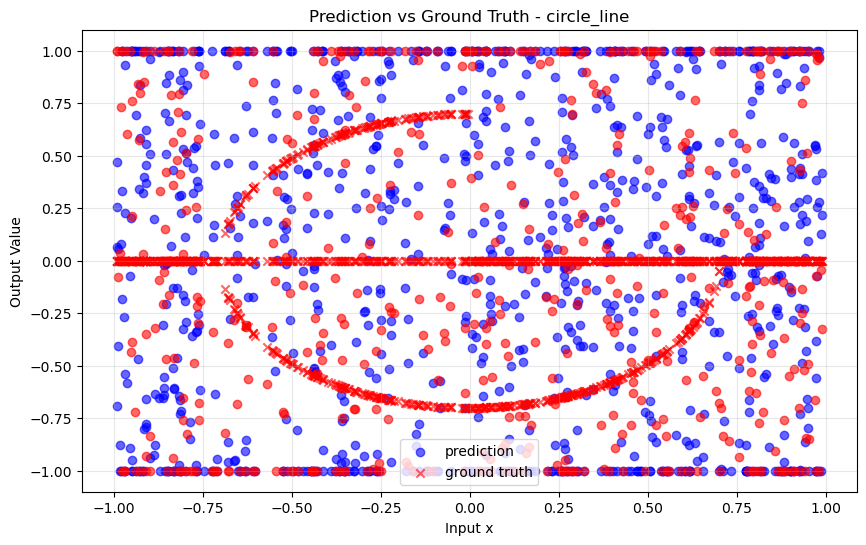

In [327]:
# 拼接所有数据（确保维度正确）
xs = np.concatenate(all_inputs, axis=0).flatten()  # 输入x（1维，总样本数）
ys_pred = np.concatenate(all_preds, axis=0)        # 预测值（[总样本数, 3]）
ys_target = np.concatenate(all_targets, axis=0)    # 目标值（[总样本数, 3]）

# 绘图
plt.figure(figsize=(10, 6))

# 因为数据是3维输出（3个维度），直接绘制三个维度的预测与真实值
# 预测值（用圆形标记，不同颜色区分维度）
plt.scatter(xs, ys_pred[:, 0], marker="o", c="blue", alpha=0.6, label="prediction")
plt.scatter(xs, ys_pred[:, 1], marker="o", c="blue", alpha=0.6)
plt.scatter(xs, ys_pred[:, 2], marker="o", c="red", alpha=0.6)

# 真实值（用叉形标记，不同颜色区分维度）
plt.scatter(xs, ys_target[:, 0], marker="x", c="red", alpha=0.6, label="ground truth")
plt.scatter(xs, ys_target[:, 1], marker="x", c="red", alpha=0.6)
plt.scatter(xs, ys_target[:, 2], marker="x", c="red", alpha=0.6)

# 图表配置
plt.title(f"Prediction vs Ground Truth - {train_dataset_config.mode}")
plt.xlabel("Input x")
plt.ylabel("Output Value")
plt.legend()  # 显示图例区分维度和预测/真实
plt.grid(alpha=0.3)  # 网格线便于观察
plt.show()